# Поисковая система изображений


## Описание проекта

Этот проект направлен на создание системы поиска изображений по тексту — приложения, позволяющего пользователям вводить текстовое описание и находить наиболее релевантные изображения из набора данных. Основные цели проекта:

1. **Доказать осуществимость**: продемонстрировать, что модель может научиться отображать изображения и текстовые описания в общее векторное пространство (или подходящую метрику), где можно измерять их сходство и использовать его для ранжирования изображений.  
2. **Исследовать несколько подходов**:  
   - **Модели на основе регрессии**, которые рассматривают соответствие изображения и текста как задачу предсказания числового балла.  
   - **Контрастивная схожесть**, где эмбеддинги изображений и текстов обучаются совместно, чтобы максимизировать согласованность совпадающих пар и разногласие несоответствующих.  
3. **Учесть юридические ограничения**: в некоторых юрисдикциях запрещено отображение или обработка изображений с детьми младше 16 лет без согласия родителей или законных представителей. Для соблюдения этих требований проект исключает изображения (и соответствующий им текст), содержащие определённые ключевые слова, относящиеся к юридическим ограничениям.  


## Настройка проекта


### Зависимости


In [1]:
import os
import random

import os
import random

from abc import ABC, abstractmethod
from dataclasses import dataclass, field
from typing import Iterable

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
from torchvision import transforms
from torchvision.models import ResNet50_Weights, resnet50
from tqdm import tqdm
from transformers import BertModel, BertTokenizer, PreTrainedTokenizer
from IPython import display
from PIL import Image, ImageEnhance

# IProgress not found: pip install ipywidgets

### Константы


In [2]:
ROOT = "datasets/to_upload"
SEED = 42
INFERENCE_REG = True
INFERENCE_SM = True

VERSION = 1

EPOCHS_LR = 5
EPOCHS_NN = 5
EPOCHS_SM = 5

MAX_AMOUNT_OF_DESCRIPTIONS = 6  # Has an impact on amount of augmented images

### Общий обзор

In [3]:
train_df = pd.read_csv(f"{ROOT}/train_dataset.csv")
train_df.info()
train_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


In [4]:
test_queries_df_ = pd.read_csv(f"{ROOT}/test_queries.csv", delimiter="|")
test_queries_df = test_queries_df_[["query_id", "query_text", "image"]]
test_queries_df.info()
test_queries_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 11.8+ KB


,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


In [5]:
crowd_df = pd.read_csv(
    f"{ROOT}/CrowdAnnotations.tsv",
    delimiter="\t",
    header=None,
    names=["image", "query_id", "match_share", "match", "not_match"]
)
crowd_df.info()
crowd_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        47830 non-null  object 
 1   query_id     47830 non-null  object 
 2   match_share  47830 non-null  float64
 3   match        47830 non-null  int64  
 4   not_match    47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


,image,query_id,match_share,match,not_match
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


In [6]:
expert_df = pd.read_csv(
    f"{ROOT}/ExpertAnnotations.tsv",
    delimiter="\t",
    header=None,
    names=["image", "query_id", "exp1", "exp2", "exp3"]
)
expert_df.info()
expert_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   exp1      5822 non-null   int64 
 3   exp2      5822 non-null   int64 
 4   exp3      5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


,image,query_id,exp1,exp2,exp3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


## Датаклассы


In [7]:
@dataclass
class Train:
    query_id: str           # Format: "<source_image>#<description_index>"
    query_text: str         # The actual text description
    label: str = None
    crowd_target: float = None
    expert_target: float = None

    def target(self) -> float:
        if isinstance(self.expert_target, float):
            if self.crowd_target is None:
                return self.expert_target
            if self.expert_target > self.crowd_target:
                return self.expert_target
        if self.crowd_target is None:
            return 0.0
        return self.crowd_target


@dataclass
class TestQuery:
    query_id: str          # Format: "<source_image>#<description_index>"
    query_text: str        # The text used as the query
    image: str             # The ground-truth image filename

In [8]:
@dataclass
class Crowd:
    query_id: str          # "<image filename>#<description_index>"
    match_share: float     # Target
    match: int             # Count of users confirming the match
    not_match: int         # Count of users indicating a mismatch

    def target(self) -> float:
        return self.match / (self.match + self.not_match)  # Can differ from match_share


@dataclass
class Expert:
    query_id: str          # Format: "<image filename>#<description_index>"
    exp1: int              # Expert 1's rating (1 to 4)
    exp2: int              # Expert 2's rating (1 to 4)
    exp3: int              # Expert 3's rating (1 to 4)

    def target(self) -> float:
        return ((self.exp1 + self.exp2 + self.exp3) - 3.0) / 9.0

In [9]:
class AugmentationFunction(ABC):
    """Abstract base class for image augmentation functions."""
    @abstractmethod
    def apply(
        self, image_data: "ImageDataBase", *_, **kwargs
    ) -> Iterable[tuple[str, float, Image.Image]]:
        """Applies augmentation and returns an iterable of (text, score, image)."""
        pass


@dataclass
class ImageDataBase:
    file_name: str
    path: str
    seed: int = 42
    train: list[Train] = field(default_factory=list)
    crowd: list[Crowd] = field(default_factory=list)
    expert: list[Expert] = field(default_factory=list)
    test: list[TestQuery] = field(default_factory=list)
    descriptions: list[str] = field(default_factory=list)
    augmentation_fx: AugmentationFunction = None

    def display_image(self, width: int = 300, height: int = None):
        display.display(
            display.Image(os.path.join(self.path), width=width, height=height)
        )

    def augmentation(self, *_, **kwargs) -> Iterable[tuple[str, float, Image.Image]]:
        try:
            img = Image.open(self.path)
        except FileNotFoundError as e:
            print(f"Unable to load image at {self.path}: {e}")
            return  # Exit the generator immediately
        if self.augmentation_fx is None:
            yield (self.descriptions[0][1], self.descriptions[0][0], img)
        elif isinstance(self.augmentation_fx, AugmentationFunction):
            yield from self.augmentation_fx.apply(self, *_, seed=self.seed, **kwargs) 

    def __str__(self, br: str = " | ") -> str:
        txt = f"Image({self.file_name}) => "
        for attr in ["train", "test", "crowd", "expert"]:
            txt += f"{br}{len(getattr(self, attr))} {attr}"
        return txt + (" - TXT: " + self.descriptions[0][1] if self.descriptions else "")

In [10]:
@dataclass
class ImageData(ImageDataBase):
    exclude: bool = False

    def set_train_target(self):
        for train_data in self.train:
            for crowd_annotation in self.crowd:
                if crowd_annotation.query_id == train_data.query_id:
                    train_data.crowd_target = crowd_annotation.target()
            for expert_annotation in self.expert:
                if expert_annotation.query_id == train_data.query_id:
                    train_data.expert_target = expert_annotation.target()

    def get_highest_scores(self, head: int = 5, subset: str = "train") -> list[Train]:
        """Returns a list of the top Train objects ranked by both expert and crowd"""
        annotations: list[Train | Crowd | Expert] = getattr(self, subset)
        if not annotations:
            return []
        return sorted(annotations, key=lambda tr: tr.target(), reverse=True)[:head]
    
    def add_best_descriptions(
        self,
        text_mapping: dict[str, str],
        head: int = 5,
        subsets: list[str] = ["crowd", "expert"],
        threshold: float = 0.0,
        rm_duplicates: bool = True
    ) -> None:
        """Adds best descriptions sorted by target"""
        self.descriptions.clear()
        ranking = []
        for subset in subsets:
            top_annotations = self.get_highest_scores(head=head, subset=subset)
            for annot in top_annotations:
                txt = text_mapping.get(annot.query_id)
                if txt and annot.target() >= threshold:
                    ranking.append((annot.target(), isinstance(annot, Expert), txt))
        ranking.sort(key=lambda x: (x[0], x[1]), reverse=True)
        if rm_duplicates:
            seen_descriptions = set()
            unique_descriptions = []
            for score, _, desc in ranking:
                if desc not in seen_descriptions:
                    seen_descriptions.add(desc)
                    unique_descriptions.append((round(score, 2), desc))
            self.descriptions = unique_descriptions[: head * len(subsets)]
        else:
            self.descriptions = [(round(score, 2), desc) for score, _, desc in ranking]



In [11]:
@dataclass
class ImageDataset:
    folder: tuple[str, tuple[str, str]]
    train: dict[str, ImageData] = field(default_factory=dict)
    test: dict[str, ImageData] = field(default_factory=dict)
    text_train: dict[str, str] = field(default_factory=dict)
    text_test: dict[str, str] = field(default_factory=dict)
    seed: int = 42

    def get_or_create_image(self, name: str, is_test: bool = False) -> ImageData:
        img_dict = self.test if is_test else self.train
        if name not in img_dict:
            path = os.path.join(self.folder[0] + self.folder[1][int(is_test)], name)
            img_dict[name] = ImageData(file_name=name, path=path, seed=self.seed)
        return img_dict[name]

    def get_or_create_text(self, query_id: str, query_text: str, is_test: bool = False
    ) -> str:
        text_dict = self.text_test if is_test else self.text_train
        if query_id in text_dict:
            existing_text = text_dict[query_id]
            if existing_text != query_text:
                raise ValueError(f"Text mismatch for {query_id}")
            return existing_text
        else:
            text_dict[query_id] = query_text
            return query_text

    def split_train(
        self, train_ratio: float = 0.8
    ) -> tuple[dict[str, ImageData], dict[str, ImageData]]:
        if not self.train:
            return {}, {}
        random.seed(self.seed)
        train_keys = list(self.train.keys())  
        random.shuffle(train_keys)
        train_size = int(len(train_keys) * train_ratio)
        train_subset_keys = train_keys[:train_size]
        val_subset_keys = train_keys[train_size:]
        train_subset = {key: self.train[key] for key in train_subset_keys}
        val_subset = {key: self.train[key] for key in val_subset_keys}
        return train_subset, val_subset
    
    def add_agmentation_generator(self, fx: AugmentationFunction = None) -> None:
        for _, img_data in self.train.items():
            img_data.augmentation_fx = fx

### Загрузка объектов с данными


In [12]:
img_dataset = ImageDataset(
    folder=(ROOT, ("/train_images", "/test_images"))
)


for idx, row in train_df.iterrows():
    img = img_dataset.get_or_create_image(row['image'])
    train_data = Train(query_id=row['query_id'], query_text=row['query_text'])
    img_dataset.get_or_create_text(train_data.query_id, train_data.query_text)
    img.train.append(train_data)


for idx, row in crowd_df.iterrows():
    img = img_dataset.get_or_create_image(row["image"])
    crowd_annotation = Crowd(
        query_id=row["query_id"],
        match_share=int(row["match_share"]),
        match=int(row["match"]),
        not_match=int(row["not_match"])
    )
    img.crowd.append(crowd_annotation)


for idx, row in expert_df.iterrows():
    image_filename = row["image"]
    img = img_dataset.get_or_create_image(row["image"])
    expert_annotation = Expert(
        query_id=row["query_id"],
        exp1=int(row["exp1"]),
        exp2=int(row["exp2"]),
        exp3=int(row["exp3"])
    )
    img.expert.append(expert_annotation)

### Пример доступа к данным

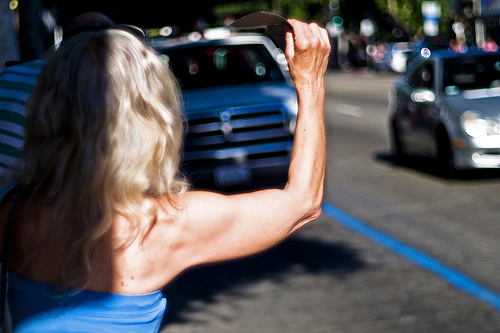

Image(1056338697_4f7d7ce270.jpg) =>  | 8 train | 0 test | 50 crowd | 8 expert


In [13]:
for _, img in img_dataset.train.items():
    img.display_image()
    print(img)
    break

### Ранжирование описаний


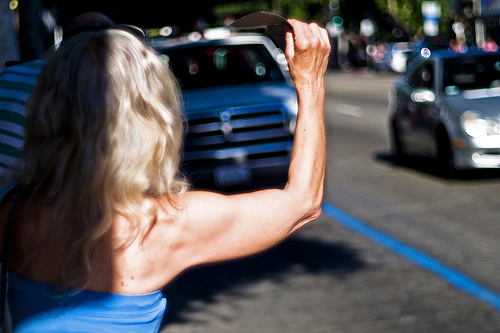

Image(1056338697_4f7d7ce270.jpg) =>  | 8 train | 0 test | 50 crowd | 8 expert

TRAIN
A woman plays with long red ribbons in an empty square . 0.2222222222222222
A girl wearing a yellow shirt and sunglasses smiles . 0.1111111111111111
A man sleeps under a blanket on a city street . 0.1111111111111111
Chinese market street in the winter time . 0.1111111111111111

CROWD
A woman is signaling is to traffic , as seen from behind . 1.0
A woman looking at view of a city . 1.0
A woman in a red shirt with her arm raised . 0.6666666666666666
A woman crosses the street near a man , who is on his cellphone . 0.3333333333333333

EXPERT
A woman plays with long red ribbons in an empty square . 0.2222222222222222
A girl wearing a yellow shirt and sunglasses smiles . 0.1111111111111111
A man sleeps under a blanket on a city street . 0.1111111111111111
Chinese market street in the winter time . 0.1111111111111111


In [14]:
for img_key in img_dataset.train:  # Update Train with crowd_target and expert_target
    img_dataset.train[img_key].set_train_target()


example_1 = img_dataset.train["1056338697_4f7d7ce270.jpg"]
example_1.display_image()
print(example_1)
head_highest_scores = 4

for subset in ["train", "crowd", "expert"]:
    print("\n"+ subset.upper())
    example_1_scores = example_1.get_highest_scores(head_highest_scores, subset=subset)
    for annotation in example_1_scores:
        print(img_dataset.text_train[annotation.query_id], annotation.target())

In [15]:
example_1.add_best_descriptions(img_dataset.text_train, head=5, threshold=0.6)
print(example_1)
example_1.descriptions

Image(1056338697_4f7d7ce270.jpg) =>  | 8 train | 0 test | 50 crowd | 8 expert - TXT: A woman is signaling is to traffic , as seen from behind .


[(1.0, 'A woman is signaling is to traffic , as seen from behind .'),
 (1.0, 'A woman looking at view of a city .'),
 (0.67, 'A woman in a red shirt with her arm raised .')]

Эти ячейки обновляют обучающие данные для каждого изображения, добавляя соответствующие оценки от краудсорсинга и экспертов с помощью `set_train_target()`. Затем, для выбранного изображения выполняются следующие шаги:

- Отображаются основные текстовые описания (и их оценки), полученные из обучающего (`train`), краудсорсингового (`crowd`) и экспертного (`expert`) наборов.
- Фильтруется набор наиболее релевантных описаний с помощью `add_best_descriptions()`, используя заданный порог. Этот отфильтрованный список может быть использован на последующих этапах моделирования или отображения.

Такой процесс позволяет увидеть, как различные аннотации (краудсорсинг против экспертов) оценивают соответствие текстового описания изображению.

## Предобработка


### Ключевые слова

**Ключевые слова, связанные с юридическими ограничениями**

In [16]:
# Compliance Processing
# =====================
compliance_keywords = [
    "child",
    "boy",
    "girl",
    "baby",
    "toddler",
    "kid",
    "infant",
    "teen",
    "teenager",
    "minor",
    "newborn",
    "preschooler",
    "youth",
]

### Загрузка и фильтрация тестовых данных


In [17]:
# Test Data
# =========
for idx, row in test_queries_df.iterrows():
    if not any(kw in str(row["query_text"]).lower() for kw in compliance_keywords):
        img = img_dataset.get_or_create_image(row['image'], is_test=True)
        test_query = TestQuery(
            query_id=row["query_id"],
            query_text=row["query_text"],
            image=row["image"]
        )
        img_dataset.get_or_create_text(
            train_data.query_id, train_data.query_text, is_test=True
        )
        img.train.append(test_query)
        img.descriptions.append((1.0, row["query_text"]))

len(img_dataset.test)

76

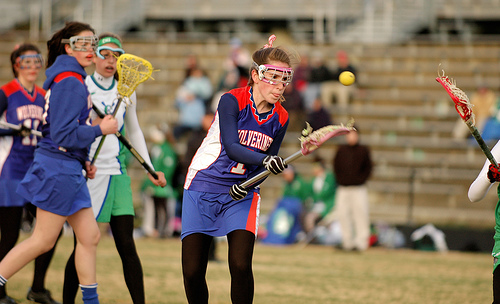

[(1.0, 'Several female lacrosse players are going after a ball .'),
 (1.0, 'The woman lacrosse player in blue is about to catch the ball .'),
 (1.0, 'Women play lacrosse .')]

In [18]:
example_2 = img_dataset.test["123997871_6a9ca987b1.jpg"]
example_2.display_image()
example_2.descriptions

### Цикл предобработк

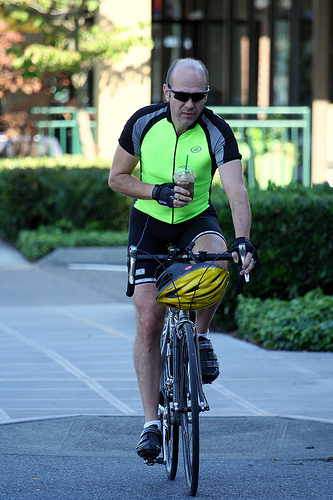

1262583859_653f1469a9.jpg
(1.0, 'A man in a bright green shirt riding a bicycle in a paved courtyard , carying a drink .')
(1.0, 'A man rides a bike through a course .')
(0.67, 'A young boy is riding a bike .')


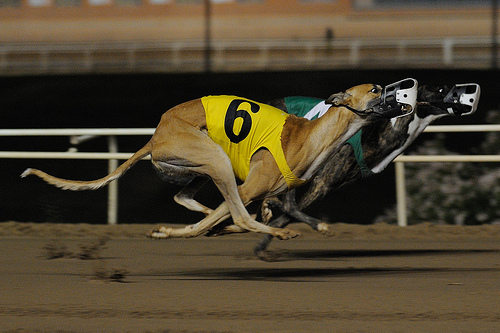

2968182121_b3b491df85.jpg
(1.0, 'A greyhound wearing a muzzle and the number six on a yellow jacket is running on a dog track .')
(1.0, 'Two greyhounds race .')
(0.67, 'A greyhound runs in a race , bee striped jacket , number eight .')


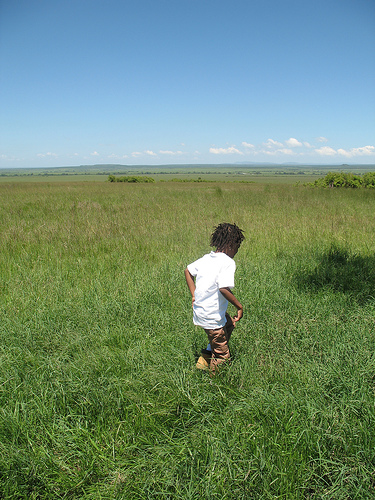

566397227_a469e9e415.jpg
(1.0, 'A small boy with braids runs through a field of tall green grass .')
(0.67, 'Two children playing with a ball on the grass .')
(0.33, 'A man in a rugby uniform hitting a ball in a grassy field .')


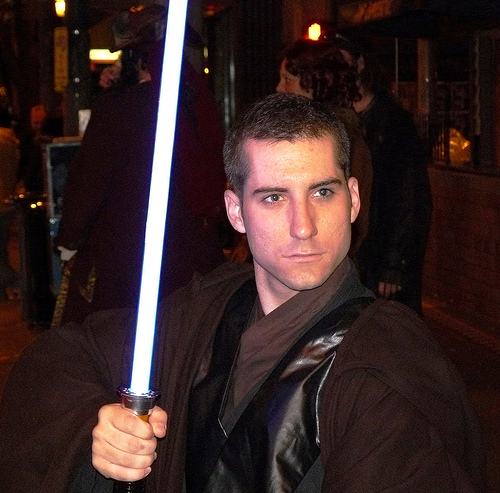

1836335410_de8313a64e.jpg
(1.0, 'Man dressed up in black and brown and holding a white light saber .')
(0.11, 'Two people are sitting next to a wood-stacked campfire at night .')
(0.11, 'two men sit on a chairlift .')


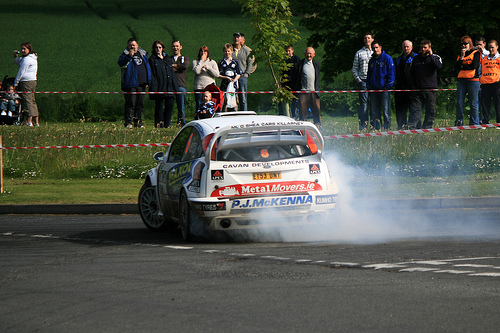

2533424347_cf2f84872b.jpg
(1.0, 'A race car screeches through a turn as spectators watch .')
(0.33, 'a red and white race car racing on a dirt racetrack .')
(0.0, 'two small brown and white dogs standing beside some white chairs')


In [19]:
description_threshold = 0.0  # adjust as trade off between amount and quality of data
subsets = ["crowd", "expert"]
for img_id, (jpg, image) in enumerate(img_dataset.train.items()):
    image.add_best_descriptions(
        img_dataset.text_train,
        head=MAX_AMOUNT_OF_DESCRIPTIONS // len(subsets),
        subsets=subsets,
        threshold=description_threshold
    )
    if len(image.descriptions) == 0:
        image.exclude = True
    elif any(kw in image.descriptions[0][1].lower() for kw in compliance_keywords):
        image.exclude = True  # Complience filter
    if img_id % 250 == 1:
        image.display_image(width=200)
        print(image.file_name)
        for cnt, description in enumerate(image.descriptions):
            if cnt == 3:
                break
            print(description)

Этот этап фильтрует описания для каждого изображения, выполняя следующие шаги:

1. **Ранжирование и выбор лучших описаний** на основе краудсорсинговых или экспертных аннотаций.  
2. **Исключение изображений**, у которых отсутствуют валидные описания, а также тех, в текстах которых содержатся ключевые слова, связанные с детьми (в целях соблюдения юридических требований).  
3. **Визуализация процесса**: каждое 250-е изображение выводится вместе с выбранными для него описаниями. 

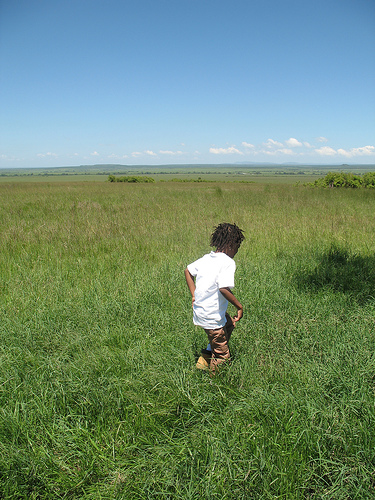

Image(566397227_a469e9e415.jpg) =>  | 7 train | 0 test | 50 crowd | 7 expert - TXT: A small boy with braids runs through a field of tall green grass .


True

In [20]:
example_3 = img_dataset.train["566397227_a469e9e415.jpg"]
example_3.display_image(width=200)
print(example_3)
example_3.exclude

In [21]:
len_before = len(img_dataset.train)
img_dataset.train = {
    jpg:img for jpg, img in img_dataset.train.items() if img.exclude == False
}
len_before, len(img_dataset.train)

(1002, 709)

Наконец, все изображения, помеченные для исключения (`image.exclude = True`), удаляются из обучающего набора данных. Это гарантирует, что в нём остаются только соответствующие требованиям и достаточно аннотированные изображения.

## Целевая переменная (EDA)

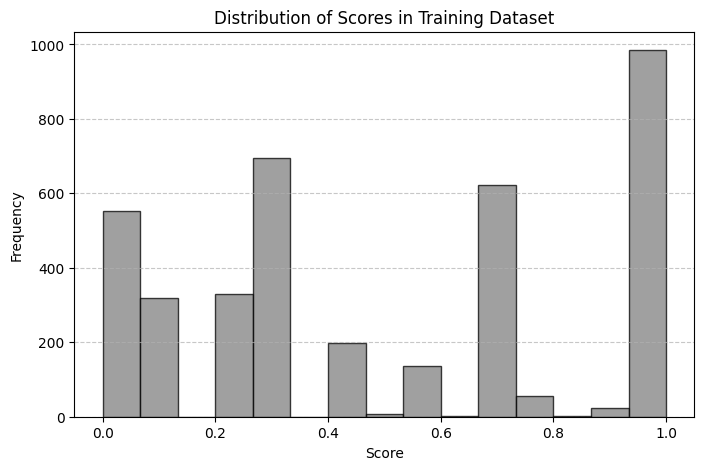

In [22]:
all_scores = [
    score for img_ in img_dataset.train.values() for score, _ in img_.descriptions
]
plt.figure(figsize=(8, 5))
plt.hist(all_scores, bins=15, edgecolor='black', color="grey", alpha=0.75)
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Distribution of Scores in Training Dataset")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Эта гистограмма показывает распределение агрегированных оценок соответствия изображений и текстовых описаний (от `0.0` до `1.0`) в обучающем наборе данных. Примечательно, что наблюдается высокая частота идеальных совпадений при значении `1.0`, а также отчетливые пики в диапазонах `0.2–0.4` и `0.6`.  

Параметр `MAX_AMOUNT_OF_DESCRIPTIONS` частично способствует смещению значений к 0.0 (низкие совпадения), так как ограничение количества высокооцененных описаний для каждого изображения оставляет многие низкооцененные пары невыбранными, что приводит к их распределению ближе к нижнему краю шкалы.